# meap analysis

MEAP data obtained from
https://www.mischooldata.org/DistrictSchoolProfiles/EntitySummary/SchoolDataFile.aspx

Staffing info from
https://www.mischooldata.org/Other/DataFiles/StaffingInformation/HistoricalStaffingSummary.aspx

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper
from os.path import exists
import qgrid as qgrid
qgrid.nbinstall()

In [4]:
# consts for column names
score_code_col = 'DistrictCode'
staff_code_col = 'DCODE'
subject_col = 'Subject Name'
grade_col = 'Grade'
subgroup_col = 'Subgroup'
num_students_col = 'Number Tested'
proficient_col = 'Percent Proficient'
avg_score_col = 'Average Scaled Score'
stddev_col = 'Standard Deviation'
num_teachers_col = 'TEACHER'
num_librarians_col = 'LIB_SPEC'
num_library_support_col = 'LIB_SUPP'

In [5]:
# basic database creation and loading funcs
# hdf is very fast but requires extra installs
# hdf5 from homebrew/science tap, tables from pip

# clean junk here
def cleanData(combined):
    combined.drop(staff_code_col, 1, inplace=True)
    
    # look at scores on district level only
    combined = combined[combined['BuildingName'] == 'All Buildings']
    combined.drop('BuildingName', 1, inplace=True)
    
    # Old format listed small number of students as '< 10' and lists no results,
    # drop these
    if combined.dtypes[num_students_col] == 'O':
        combined = combined[combined[num_students_col] != '< 10']

    # New formats list small proficiencies as '< 5%'
    # Round to 5 to convert to numeric.
    if combined.dtypes[proficient_col] == 'O':
        percent_idx = combined[proficient_col] == '< 5%'
        combined.loc[percent_idx, proficient_col] = 5
        
    combined.loc[:, num_students_col] = pd.to_numeric(combined[num_students_col])
    combined.loc[:, proficient_col] = pd.to_numeric(combined[proficient_col])
    combined.loc[:, avg_score_col] = pd.to_numeric(combined[avg_score_col])
    combined.loc[:, stddev_col] = pd.to_numeric(combined[stddev_col])
    
    # replace NAN librarian cells with 0
    combined.loc[:, num_teachers_col].fillna(0, inplace=True)
    combined.loc[:, num_librarians_col].fillna(0, inplace=True)
    combined.loc[:, num_library_support_col].fillna(0, inplace=True)
    
    return combined

# I/O here
hdf_key = 'table'
def buildAndSaveCombinedSet(meap_csv, staff_csv, hdf_file):
    scores = pd.read_csv(meap_csv)
    scores.drop('BuildingCode', 1, inplace=True)

    staff = pd.read_csv(staff_csv)
    staff.drop('DNAME', 1, inplace=True)

    combined = pd.merge(scores, staff, left_on=score_code_col, right_on=staff_code_col)
    combined = cleanData(combined)
    combined.to_hdf(hdf_file, hdf_key, mode='w')

2012-2013.

In [6]:
# build and load hdf5 for 12-13.
combined_12_hdf = 'all_data-12-13.hdf'
if not exists(combined_12_hdf):
    buildAndSaveCombinedSet('csv/meap-12-13.csv', 'csv/staff-12-13.csv', combined_12_hdf)

combined_12 = pd.read_hdf(combined_12_hdf, hdf_key)
# print list of columns
combined_12.columns

Index(['SchoolYear', 'ISDCode', 'ISDName', 'DistrictCode', 'DistrictName',
       'Grade', 'Subject Name', 'Subgroup', 'Number Tested',
       'Level 1 Proficient', 'Level 2 Proficient', 'Level 3 Proficient',
       'Level 4 Proficient', 'Percent Proficient', 'Average Scaled Score',
       'Standard Deviation', 'TEACHER', 'INST_AID', 'INST_SUP', 'GUIDANCE',
       'LIB_SPEC', 'LIB_SUPP', 'LEA_ADM', 'LEA_SUPP', 'SCH_ADM', 'SCH_SUPP',
       'STU_SUPP', 'OTH_SUPP', 'SE_INSTR', 'SE_SUBJ', 'SE_CONS', 'SE_AID',
       'SE_SUPP', 'SE_OTH', 'CT_TEACH', 'CONS', 'LEA_DIR', 'COORD', 'SUPERVSR',
       'SCH_DIR'],
      dtype='object')

2013-2014

In [6]:
# build and load hdf5 for 13-14.
combined_13_hdf = 'all_data-13-14.hdf'
if not exists(combined_13_hdf):
    buildAndSaveCombinedSet('csv/meap-13-14.csv', 'csv/staff-13-14.csv', combined_13_hdf)

combined_13 = pd.read_hdf(combined_13_hdf, hdf_key)
# print list of columns
combined_13.columns

Index(['SchoolYear', 'ISDCode', 'ISDName', 'DistrictCode', 'DistrictName',
       'Grade', 'Subject Name', 'Subgroup', 'Number Tested',
       'Level 1 Proficient', 'Level 2 Proficient', 'Level 3 Proficient',
       'Level 4 Proficient', 'Percent Proficient',
       'Average Scaled Score (rounded)', 'TEACHER', 'INST_AID', 'INST_SUP',
       'GUIDANCE', 'LIB_SPEC', 'LIB_SUPP', 'LEA_ADM', 'LEA_SUPP', 'SCH_ADM',
       'SCH_SUPP', 'STU_SUPP', 'OTH_SUPP', 'SE_INSTR', 'SE_SUBJ', 'SE_CONS',
       'SE_AID', 'SE_SUPP', 'SE_OTH', 'CT_TEACH', 'CONS', 'LEA_DIR', 'COORD',
       'SUPERVSR', 'SCH_DIR'],
      dtype='object')

In [7]:
# print valid grades + subjects
# look at both together, as not all subjects are tested at each grade level
valid_grade_subject = list(combined_12.groupby([grade_col, subject_col], sort=True).groups.keys())
valid_grade_subject.sort()
valid_grade_subject

[(3, 'Mathematics'),
 (3, 'Reading'),
 (4, 'Mathematics'),
 (4, 'Reading'),
 (4, 'Writing'),
 (5, 'Mathematics'),
 (5, 'Reading'),
 (5, 'Science'),
 (6, 'Mathematics'),
 (6, 'Reading'),
 (6, 'Social Studies'),
 (7, 'Mathematics'),
 (7, 'Reading'),
 (7, 'Writing'),
 (8, 'Mathematics'),
 (8, 'Reading'),
 (8, 'Science'),
 (9, 'Social Studies')]

In [8]:
combined_12.groupby(subgroup_col).groups.keys()

dict_keys(['Hispanic', 'Male', 'Two or More Races', 'Not English Language Learners', 'American Indian or Alaskan Native', 'Female', 'All Students', 'White, not of Hispanic origin', 'Black, not of Hispanic origin', 'Not Economically Disadvantaged', 'Economically Disadvantaged', 'English Language Learners', 'Students with Disabilities', 'Native Hawaiian or Other Pacific Islander', 'Asian'])

There are some weird schools. Detroit has way more teachers than every other school (2323.7), and one school has 0 teachers (but 3 career teachers).

In [7]:
all_subgroup = 'All Students'
poor_subgroup = 'Economically Disadvantaged'

In [8]:
# compare scores only within a single grade + subject combination
def examineFor(database, grade, subject, subgroup):
    grouped = database.groupby([grade_col, subject_col, subgroup_col])

    data = grouped.get_group((grade, subject, subgroup))
    data = data.drop(grade_col, 1).drop(subject_col, 1).drop(subgroup_col, 1)
    
    return data

In [10]:
# test with 8th grade reading.
data = examineFor(combined_12, 8, 'Reading', 'All Students')

In [11]:
# summary statistics
total = data.shape[0]
desc_data = data[[num_students_col, proficient_col, avg_score_col, 
                  stddev_col, num_teachers_col, num_librarians_col, num_library_support_col]]
desc_data.describe()

,Number Tested,Percent Proficient,Average Scaled Score,Standard Deviation,TEACHER,LIB_SPEC,LIB_SUPP
count,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,160.759019,62.277778,825.996349,23.131515,99.691905,0.798788,0.764012
std,237.327433,15.218558,9.062744,2.994371,152.289482,2.315006,2.008205
min,10.000000,0.000000,785.670000,11.480000,0.000000,0.000000,0.000000
25%,47.000000,54.200000,821.280000,21.350000,30.510000,0.000000,0.000000
50%,88.000000,64.500000,826.990000,23.150000,55.670000,0.000000,0.000000
75%,183.000000,72.600000,831.340000,24.990000,111.560000,1.000000,0.500000
max,3132.000000,100.000000,850.670000,40.890000,2323.700000,25.700000,15.390000


In [20]:
# Librarian specific stats
idx_w_teachers = data[num_librarians_col] > 0
percent_w_teachers = np.sum(idx_w_teachers) / total
print("Percent of schools with librarians: " + str(percent_w_teachers))
print("")
scores_w = data[idx_w_teachers][avg_score_col]
scores_wo = data[idx_w_teachers == 0][avg_score_col]
print("Average score w librarians: " + str(np.average(scores_w)))
print("Average score wo librarians: " + str(np.average(scores_wo)))
print("")
percent_prof_w = data[idx_w_teachers][proficient_col]
percent_prof_wo = data[idx_w_teachers == 0][proficient_col]
avg_prof_w = np.average(percent_prof_w)
avg_prof_wo = np.average(percent_prof_wo)
print("Average proficiency w librarians: " + str(avg_prof_w))
print("Std: " + str(np.std(percent_prof_w)))
print("Average proficiency wo librarians: " + str(avg_prof_wo))
print("Std: " + str(np.std(percent_prof_wo)))
print("Diff: " + str((avg_prof_w / avg_prof_wo - 1) * 100) + "%")
print("")
print("Norm test on with: " + str(stats.normaltest(percent_prof_w)))
print("Norm test on without: " + str(stats.normaltest(percent_prof_wo)))
print("T-test: " + str(stats.ttest_ind(percent_prof_w, percent_prof_wo)))

Percent of schools with librarians: 0.336219336219

Average score w librarians: 828.458111588
Average score wo librarians: 824.749413043

Average proficiency w librarians: 65.9991416309
Std: 13.9403018773
Average proficiency wo librarians: 60.392826087
Std: 15.4729670524
Diff: 9.28308196055%

Norm test on with: NormaltestResult(statistic=26.253349855949203, pvalue=1.9913954616400677e-06)
Norm test on without: NormaltestResult(statistic=43.95504343865484, pvalue=2.8528805713026742e-10)
T-test: Ttest_indResult(statistic=4.6490953086250846, pvalue=3.9942978335124898e-06)


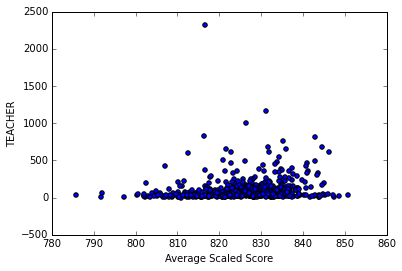

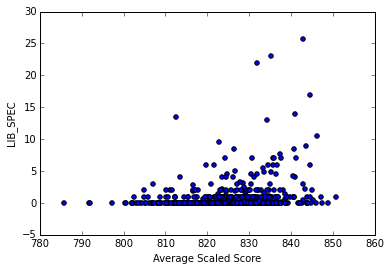

In [11]:
# examining avg_score_col asks: do kids score better on average?
data.plot(x=avg_score_col, y=num_teachers_col, kind='scatter')
data.plot(x=avg_score_col, y=num_librarians_col, kind='scatter')

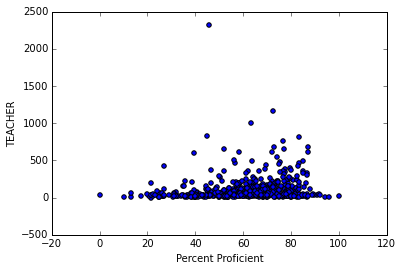

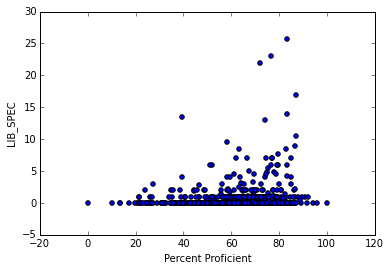

In [12]:
# examining proficient_col asks: do more kids pass?
data.plot(x=proficient_col, y=num_teachers_col, kind='scatter')
data.plot(x=proficient_col, y=num_librarians_col, kind='scatter')

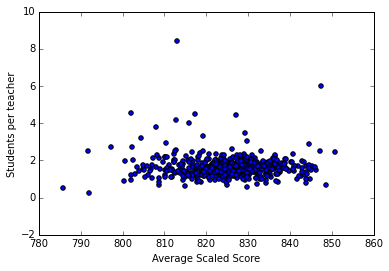

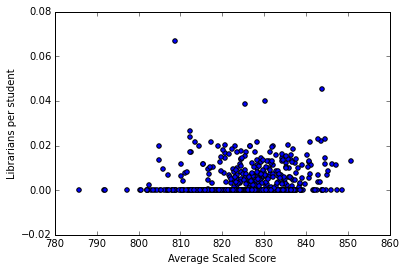

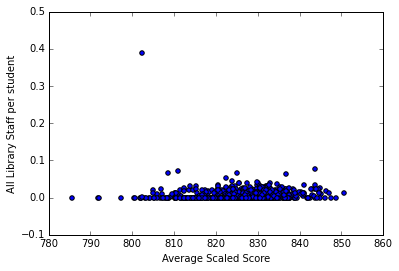

In [13]:
students_per_teacher_col = 'Students per teacher'
data.loc[:,students_per_teacher_col] = data[num_students_col].values / data[num_teachers_col].values
data.plot(x=avg_score_col, y=students_per_teacher_col, kind='scatter')

# since many districts have no librarians and dividing by zero is out
# use librarians / student instead of students / librarian
librarian_per_student_col = 'Librarians per student'
data.loc[:,librarian_per_student_col] = data[num_librarians_col].values / data[num_students_col].values
data.plot(x=avg_score_col, y=librarian_per_student_col, kind='scatter')

# add in library support
all_library_per_student_col = 'All Library Staff per student'
data.loc[:,all_library_per_student_col] = (data[num_librarians_col].values + data[num_library_support_col].values) / data[num_students_col].values
data.plot(x=avg_score_col, y=all_library_per_student_col, kind='scatter')

In [14]:
def runRegression(data, x_col, y_col, basis_degree=2):
    ''' From librarians / student predict the percent proficient.
    '''
    scaler = StandardScaler()
    model = make_pipeline(scaler,
                          PolynomialFeatures(basis_degree),
                          LinearRegression())
    x = data[librarian_per_student_col].values
    X = x[:, np.newaxis]
    y = data[y_col].values
    model.fit(X, y)
    x_truth = scaler.fit_transform(X)
    x_plot = np.linspace(x_truth.min(),x_truth.max(),1000)
    X_plot = x_plot[:, np.newaxis]
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, label="prediction")
    plt.scatter(x_truth, y, label="truth")
    plt.legend(loc='lower right')
    plt.show()
    # ideally we'd get a second data set to score on
    # different year, maybe
    print('R^2: ' + str(model.score(X, y)))

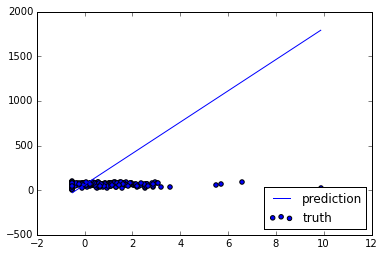

R^2: 0.00546659277697


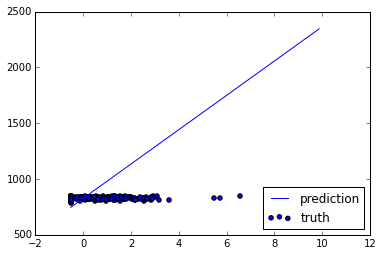

R^2: 0.0119010262896


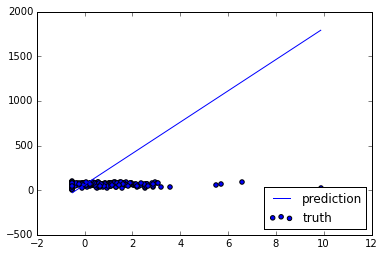

R^2: 0.00546659277697


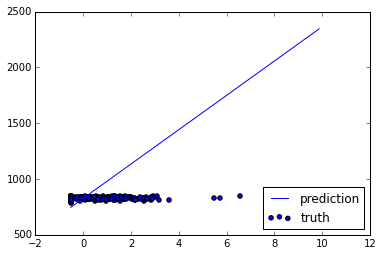

R^2: 0.0119010262896


In [15]:
runRegression(data, librarian_per_student_col, proficient_col, 1)
runRegression(data, librarian_per_student_col, avg_score_col, 1)
runRegression(data, all_library_per_student_col, proficient_col, 1)
runRegression(data, all_library_per_student_col, avg_score_col, 1)

Nope.

Logistic regression

In [22]:
def logit(x):
    return 1 / (1 + np.exp(-x))

def runLogistic(data, x_col, y_col, basis_degree=1, threshold=50):
    ''' From librarians / student predict the percent proficient.
    '''
    scaler = StandardScaler()
    regression = LogisticRegressionCV(Cs=5, penalty='l2', solver='liblinear')
    model = make_pipeline(scaler,
#                           PolynomialFeatures(basis_degree),
                          regression)
    x = data[librarian_per_student_col].values
    X = x[:, np.newaxis]
    y = (data[y_col].values > threshold).astype('int')
    model.fit(X, y)
    # plot
    x_truth = scaler.transform(X)
    x_plot = np.linspace(x_truth.min(),x_truth.max(),1000)
    y_plot = logit(x_plot * regression.coef_ + regression.intercept_).ravel()
    plt.plot(x_plot, y_plot, label="prediction")
    plt.scatter(x_truth, y, label="truth")
    plt.legend(loc='lower right')
    plt.show()
    # ideally we'd get a second data set to score on
    # different year, maybe
    print('Accuracy: ' + str(model.score(X, y)))

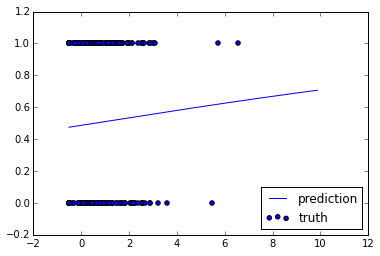

Accuracy: 0.558441558442


In [38]:
runLogistic(data, librarian_per_student_col, proficient_col, 1, 65)
#runLogistic(data, librarian_per_student_col, avg_score_col, 1)
#runLogistic(data, all_library_per_student_col, proficient_col, 1)
#runLogistic(data, all_library_per_student_col, avg_score_col, 1)

In [37]:
# For a given proficiency percentage: what percent of schools beat it?
proscr = data[proficient_col].values
above_fifty = np.sum((proscr > 65).astype('int'))

print(above_fifty / proscr.shape[0])

0.479076479076


4th grade reading.

In [9]:
# test with 4th grade reading.
data4 = examineFor(combined_12, 4, 'Reading', 'All Students')

In [30]:
# summary statistics
total = data4.shape[0]
desc_data = data4[[num_students_col, proficient_col, avg_score_col, 
                  stddev_col, num_teachers_col, num_librarians_col, num_library_support_col]]
desc_data.describe()

,Number Tested,Percent Proficient,Average Scaled Score,Standard Deviation,TEACHER,LIB_SPEC,LIB_SUPP
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,146.694444,64.525972,430.691889,25.327944,96.633528,0.778556,0.722792
std,230.119848,16.652309,10.671594,3.568205,150.201279,2.275024,1.958220
min,10.000000,11.800000,394.110000,13.460000,4.500000,0.000000,0.000000
25%,43.000000,55.300000,424.660000,23.157500,28.857500,0.000000,0.000000
50%,81.000000,67.500000,431.760000,25.455000,52.090000,0.000000,0.000000
75%,157.500000,76.700000,438.180000,27.345000,108.030000,1.000000,0.407500
max,3548.000000,100.000000,456.950000,49.740000,2323.700000,25.700000,15.390000


In [35]:
# Librarian specific stats
idx_w_teachers = data4[num_librarians_col] > 0
percent_w_teachers = np.sum(idx_w_teachers) / total
print("Percent of schools with librarians: " + str(percent_w_teachers))

scores_w = data4[idx_w_teachers][avg_score_col]
scores_wo = data4[idx_w_teachers == 0][avg_score_col]
print("Average score w librarians: " + str(np.average(scores_w)))
print("Average score wo librarians: " + str(np.average(scores_wo)))

percent_prof_w = data4[idx_w_teachers][proficient_col]
percent_prof_wo = data4[idx_w_teachers == 0][proficient_col]
avg_prof_w = np.average(percent_prof_w)
avg_prof_wo = np.average(percent_prof_wo)
print("Average proficiency w librarians: " + str(avg_prof_w))
print("Average proficiency wo librarians: " + str(avg_prof_wo))
print("Diff: " + str((avg_prof_w / avg_prof_wo - 1) * 100) + "%")

ttest_ind(percent_prof_w, percent_prof_wo)

Percent of schools with librarians: 0.333333333333
Average score w librarians: 433.819375
Average score wo librarians: 429.128145833
Average proficiency w librarians: 68.70125
Average proficiency wo librarians: 62.4383333333
Diff: 10.0305634893%


Ttest_indResult(statistic=4.8306437012233197, pvalue=1.664434307435971e-06)

In [10]:
# correlation b/w SES and librarians
data4Dis = examineFor(combined_12, 4, 'Reading', poor_subgroup)
desc_data4Dis = data4Dis[[num_students_col, proficient_col, avg_score_col, 
                  stddev_col, num_teachers_col, num_librarians_col, num_library_support_col]]
desc_data4Dis.describe()

,Number Tested,Percent Proficient,Average Scaled Score,Standard Deviation,TEACHER,LIB_SPEC,LIB_SUPP
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,77.409158,57.573117,425.374269,24.154594,101.468301,0.824682,0.759616
std,148.165097,14.904889,8.560548,3.667812,153.531306,2.338034,2.011485
min,10.000000,8.300000,394.980000,13.430000,5.000000,0.000000,0.000000
25%,29.000000,48.100000,420.580000,21.900000,31.010000,0.000000,0.000000
50%,50.000000,59.700000,426.430000,23.890000,57.000000,0.000000,0.000000
75%,79.000000,68.000000,431.030000,26.110000,113.000000,1.000000,0.500000
max,3040.000000,92.300000,453.870000,42.130000,2323.700000,25.700000,15.390000


(720, 37)
(677, 37)
(677, 37)
True


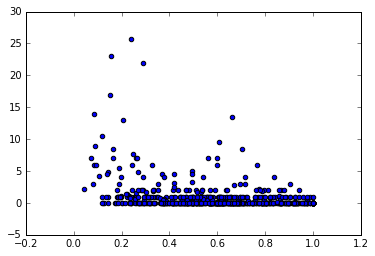

In [22]:
print(data4.shape)
print(data4Dis.shape)

num_rich_schools = data4.shape[0] - data4Dis.shape[0]

not_rich_ids = data4Dis[score_code_col]
data4AllNotRich = data4[numpy.in1d(data4[score_code_col], not_rich_ids)]

print(data4AllNotRich.shape)

print(numpy.all(data4AllNotRich[score_code_col] == data4Dis[score_code_col]))

percent_dis = np.divide(data4Dis[num_students_col], data4AllNotRich[num_students_col])
percent_dis.describe()
data4DisPlot = np.array([percent_dis, data4[num_librarians_col]])

plt.scatter(percent_dis, data4AllNotRich[num_librarians_col])